# 2. Logistic Regression

We load our and display output from data preparation section and continue to our first model, based on logistic regression. (See notebook "loan_default_data_preparation" for details on the data generation and distributions)


In [24]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Load the data
with open('data/loan_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

df = loaded_data['df']
metadata_df = loaded_data['metadata_df']
numeric_features = loaded_data['numeric_features']  # 
categorical_features = loaded_data['categorical_features']
target_feature = loaded_data['target_feature']

# Display metadata of the synthetic data distribution
# Style the DataFrame for better readability
styled_df = metadata_df.style.set_properties(**{'text-align': 'left'})
styled_df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

# Display the styled DataFrame
display(styled_df)




,Feature,Skewness Description,Mean/Mode Assumptions and Distribution Details
0,Income,"Positively skewed. Higher concentration of individuals with lower incomes, with fewer high-income earners.","Mean: €4000, Distribution: Log-normal with σ = 0.5"
1,Loan_Amount,"Positively skewed. Loan amounts are concentrated towards lower to moderate values, with fewer large loan amounts.","Mean: €175,000, Distribution: Log-normal with σ = 0.5"
2,Credit_Score,"Negatively skewed. Most people have good to excellent credit scores, with fewer individuals having very low credit scores.","Mean: 700, Mode: 750, Distribution: Normal (reversed) with μ = 100 and σ = 50"
3,Employment_Status,"Binary distribution. Higher proportion of the population being employed, heavily weighted towards employment.","Mode: Employed, Distribution: Binary with p = 0.9"
4,Debt_to_Income,"Positively skewed. More individuals with lower ratios, but significant instances of high debt relative to income.","Mean: 0.6, Distribution: Beta (α = 2, β = 5) scaled to [0, 1.2]"
5,Loan_Term,Discrete uniform. Distributed across specific intervals with peaks at common loan terms like 20 and 30 years.,"Mode: 20 years, Distribution: Discrete with p = [0.1, 0.2, 0.3, 0.1, 0.3]"
6,Age,"Approximately normal. Centered around peak working ages (30-45 years), with fewer young and old applicants.","Mean: 35, Distribution: Normal with μ = 35 and σ = 10, clipped to [18, 75]"
7,Home_Ownership,"Binary distribution. Higher proportion of the population owning homes, heavily weighted towards ownership.","Mode: Own, Distribution: Binary with p = 0.7"
8,Default,"Positively skewed. Default rates are typically low, with a small percentage representing defaults.","Mean: 0.15, Distribution: Top 15% of risk scores"


In [3]:
# Combine all features
all_features = numeric_features + categorical_features + [target_feature]

# Filter the dataframe
df_filtered = df[all_features]

df_filtered.head()

,Income,Loan_Amount,Credit_Score,Debt_to_Income,Age,Employment_Status,Home_Ownership,Loan_Term,Default
0,5127.670373,183807.505965,848.470271,0.331069,39,Employed,Own,30,0
1,3732.813394,169479.480329,850.000000,0.193608,21,Employed,Rent,30,0
2,5529.728012,281654.558991,850.000000,0.463659,44,Employed,Own,25,0
3,8566.072041,376606.751901,850.000000,0.433488,44,Employed,Rent,15,0
4,3558.067903,246708.985583,850.000000,0.222574,35,Employed,Own,20,0


### 2.2 Form naive logistic regression model 

#### 2.2.1 Train the model
We prepare our data and train our model

In [4]:
random_seed = 42

# Separate features (X) and target variable (y)
X = df_filtered.drop(columns=[target_feature])
y = df_filtered[target_feature]

# Encoding categorical features
le = LabelEncoder()
for col in categorical_features:
    X[col] = le.fit_transform(X[col])

# Encoding target variable
y = le.fit_transform(y)

# Standardizing the numeric features
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X.describe()

,Income,Loan_Amount,Credit_Score,Debt_to_Income,Age,Employment_Status,Home_Ownership,Loan_Term
count,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.000000,50000.00000,50000.000000
mean,2.042633e-16,1.628225e-16,3.669021e-16,2.586731e-16,-2.006066e-15,0.101840,0.29772,2.099720
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,0.302441,0.45726,1.131778
min,-1.703831e+00,-1.695929e+00,-1.329898e+01,-1.782191e+00,-1.930608e+00,0.000000,0.00000,0.000000
25%,-6.985857e-01,-6.925444e-01,3.191564e-01,-7.797536e-01,-7.193243e-01,0.000000,0.00000,1.000000
50%,-2.190669e-01,-2.197733e-01,3.191564e-01,-1.279533e-01,-5.862394e-02,0.000000,0.00000,2.000000
75%,4.488692e-01,4.417927e-01,3.191564e-01,6.476407e-01,7.121931e-01,0.000000,1.00000,3.000000
max,1.371765e+01,9.325957e+00,3.191564e-01,4.060830e+00,4.235928e+00,1.000000,1.00000,4.000000


In [5]:
# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

# Split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=random_seed, stratify=y_train_val
)

In [6]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#### 2.2.2 Evaluate naive logistic regression model 
We evaluate our model with the validation set

In [7]:
# Predictions on the validation set
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1] # probabilities for positive class (default)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.8627
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      8388
           1       0.67      0.29      0.40      1612

    accuracy                           0.86     10000
   macro avg       0.78      0.63      0.66     10000
weighted avg       0.84      0.86      0.84     10000



We notice that the logistic regression model demonstrates significant skewness towards predicting non-defaulters (Class 0) effectively, with a high precision of 88% and recall of 97%, which accounts for its overall accuracy of 86.27%. 

The model performs poorly for our main goal to predict defaulters (Class 1), the minority class, with a notably low recall of 29% and an F1-score of 0.40.

### 2.3 Model Logistic Regression with balanced class weights
We attempt to improve this performance with a model with balanced class weights

In [10]:
# Create the logistic regression model with balanced class weights
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [11]:
# Predictions on the validation set
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1] # probabilities for positive class (default)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.765
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85      8388
           1       0.38      0.74      0.50      1612

    accuracy                           0.77     10000
   macro avg       0.66      0.75      0.67     10000
weighted avg       0.85      0.77      0.79     10000



#### 2.3.2 Evaluate logistic regression model with balanced class weights

- **Class 1 (Defaulters)**:
  - **Recall**: Significantly improved to 74% from 29%, showing the model's enhanced capability to identify actual defaulters, which is crucial for risk-sensitive applications.
  - **Precision**: Reduced to 38% from 67%, indicating an increase in false positives as the model now labels more non-defaulters as defaulters.
  - **F1-Score**: Improved to 0.50 from 0.40, indicating better overall performance in predicting defaulters through a balance between precision and recall.

The application of balanced class weights has effectively shifted the model's sensitivity towards better identifying the minority class (defaulters), crucial for applications such as financial risk management where the cost of missing a default is higher than the cost of a false positive. 


Several techniques could futher enhance the logistic regression model's ability to predict defaulters more accurately and efficiently:

1. **Feature Engineering**:
   - **Enhance Feature Selection**: Investigate which features most strongly correlate with defaulters and consider adding new features or removing irrelevant ones based on feature importance analysis.
   - **Advanced Transformations**: Apply polynomial or interaction terms to existing features to capture complex patterns and interactions in the data.

2. **Data Sampling Techniques**:
   - **Oversampling the Minority Class**: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic examples rather than merely re-balancing class weights, potentially leading to better learner robustness.
   - **Undersampling the Majority Class**: This can help balance the dataset without introducing synthetic variability, although it may lead to the loss of valuable information.

3. **Algorithm Tuning**:
   - **Threshold Adjustment**: Adjust the decision threshold of the logistic model to optimize for recall, potentially improving the trade-offs between different performance metrics.

Feature engineering would be more pertinent with a real life dataset with more features. 

We shall attempt oversampling, then move on to develop our alternative Random Forest model. 

### 2.4 Logistic regression model with balanced class weights oversampling

### 2.4.1 Form logistic regression model with balanced class weights oversampling

In [17]:
random_seed = 42

def train_and_evaluate(X_train, y_train, X_val, y_val, oversampling_ratio):
    """Trains a logistic regression model with oversampling and evaluates it on the validation set.

    Args:
        X_train: Training features.
        y_train: Training labels.
        X_val: Validation features.
        y_val: Validation labels.
        oversampling_ratio: Ratio to oversample the minority class.

    Returns:
        A dictionary of evaluation metrics (accuracy, classification report, ROC AUC).
    """
    # Find minority and majority classes
    minority_class = 1
    minority_indices = np.where(y_train == minority_class)[0]
    majority_indices = np.where(y_train != minority_class)[0]
    minority_count = len(minority_indices)

    # Calculate samples to add
    samples_to_add = int(minority_count * oversampling_ratio)
    random_minority_indices = np.random.choice(minority_indices, size=samples_to_add, replace=True)

    # Concatenate
    X_train_res = np.concatenate((X_train.to_numpy(), X_train.to_numpy()[random_minority_indices]))
    y_train_res = np.concatenate((y_train, y_train[random_minority_indices]))
    
    # Convert X_train_res back to a DataFrame
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)  # Assuming X_train is a DataFrame

    # Train model
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train_res, y_train_res)

    # Predict and evaluate
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    return {'accuracy': accuracy, 'report': report}



oversampling_ratios = [0.25, 0.5, 0.75]  # Start with a few key ratios, can adjust later

results = {}
for ratio in oversampling_ratios:
    print(f"\nEvaluating with oversampling ratio: {ratio}")
    results[ratio] = train_and_evaluate(X_train, y_train, X_val, y_val, ratio)
    print(results[ratio]['report'])


Evaluating with oversampling ratio: 0.25
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      8388
           1       0.38      0.74      0.50      1612

    accuracy                           0.77     10000
   macro avg       0.66      0.75      0.67     10000
weighted avg       0.85      0.77      0.79     10000


Evaluating with oversampling ratio: 0.5
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      8388
           1       0.38      0.74      0.50      1612

    accuracy                           0.76     10000
   macro avg       0.66      0.75      0.67     10000
weighted avg       0.85      0.76      0.79     10000


Evaluating with oversampling ratio: 0.75
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      8388
           1       0.38      0.74      0.50      1612

    accuracy                           0.76     10000
   

X_train columns shape: (8,)
Coefficients shape: (1, 8)


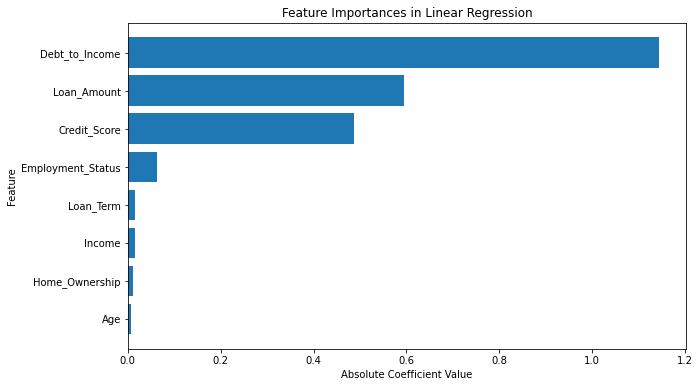

In [25]:
# Extract the coefficients
coefficients = model.coef_

# Check the shape of X_train.columns and coefficients
print("X_train columns shape:", X_train.columns.shape)
print("Coefficients shape:", coefficients.shape)

# Flatten the coefficients array if necessary
if coefficients.ndim > 1:
    coefficients = coefficients.flatten()

# Create a DataFrame for better visualization
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Calculate the absolute values of the coefficients for importance
features['Importance'] = features['Coefficient'].abs()

# Sort the DataFrame by importance
features = features.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances in Linear Regression')
plt.gca().invert_yaxis()
plt.show()

#### 2.4.2 Evaluate logistic regression model with balanced class weights oversampling

We note that ovesampling does not improve our results, and the best results still come from the logistic regression model with balanced class weights. 

We also note that the key features discovered by our logistic model match those discovered in our data exploration section. 


### 2.5 Evaluating best logistic regression model on test set 
We run our logistic regression model with balanced class weights on the test set: 

In [19]:
# Create the logistic regression model with balanced class weights
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class (default)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)


Accuracy: 0.7539
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84      8388
           1       0.37      0.73      0.49      1612

    accuracy                           0.75     10000
   macro avg       0.65      0.75      0.66     10000
weighted avg       0.84      0.75      0.78     10000



The model performs comparably on the test set as the validation set, suggesting no noticeable overfitting. 

We accept this final logistic regression model performance and attempt to improve the results with a Random Forest model. 